In [1]:
# import pandas as pd 
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error
# import numpy as np
# from sklearn.model_selection import train_test_split
# X = pd.read_csv('/gdrive/MyDrive/cleaned_training_data_01.csv')
# X['average_delay'] = X['carrier_delay'] + X['nas_delay'] + X['late_aircraft_delay']
# X = X[['crs_arr_time','actual_elapsed_time','distance','year','month','day','weekday','average_delay']]
# y = X['arr_delay']
# reg = RandomForestRegressor(n_estimators=100)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# reg.fit(X_train,y_train)

# y_pred=reg.predict(X_test)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# rmse

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [4]:
import pandas as pd 
import numpy as np
from sklearn.utils import shuffle

In [44]:
df = pd.read_csv('/gdrive/MyDrive/data_for_model_iterations_03.csv')

In [49]:
row_has_NaN = df.isnull().any(axis=1)
rows_with_NaN = df[row_has_NaN]
print(rows_with_NaN)
df.loc[189984]

           fl_date mkt_unique_carrier  ... weekday  total_carrier_delay
189984  2018-09-23                 DL  ...     1.0                  NaN

[1 rows x 25 columns]


fl_date                2018-09-23
mkt_unique_carrier             DL
op_unique_carrier              DL
op_carrier_fl_num             890
origin                        DTW
dep_time                      655
crs_dep_time                  700
dep_delay                      -5
dest                          RDU
arr_time                      824
arr_delay                     -24
crs_arr_time                  848
actual_elapsed_time            89
crs_elapsed_time              108
distance                      501
carrier_delay                   0
weather_delay                   0
nas_delay                       0
security_delay                  0
late_aircraft_delay             0
year                         2018
month                           9
day                            23
weekday                         1
total_carrier_delay           NaN
Name: 189984, dtype: object

In [6]:
weatherdf = pd.read_csv('/gdrive/MyDrive/weather.csv')

In [7]:
weatherdf = weatherdf[['date','airport_code','visibility','value']]


In [8]:
weatherdf = weatherdf.rename({'date':'fl_date','airport_code':'origin'},axis=1)


In [9]:
df = df.merge(weatherdf, on=['fl_date','origin'])


In [10]:
import sklearn.preprocessing
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [11]:
df['op_unique_carrier'] = df.op_unique_carrier.astype('category').cat.codes.astype('category')
df['origin'] = df.origin.astype('category').cat.codes.astype('category')
df['dest'] = df.dest.astype('category').cat.codes.astype('category')
df['visibility'] = df.visibility.astype('category').cat.codes.astype('category')

In [12]:
def crs_dep(row):
  if row['crs_dep_time'] < 0:
    return 2400 + row['crs_dep_time']
  else:
    return row['crs_dep_time']

In [13]:
def value(row):
  if 'snow' in row['value']:
    return 'Snow'
  elif 'rain' in row['value']:
    return 'Rain'
  elif 'showers' in row['value']:
    return 'Rain'
  elif 'possible' in row['value']:
    return 'Rain'
  elif 'drizzle' in row['value']:
    return 'Rain'
  elif 'sleet' in row['value']:
    return 'Rain/Snow'
  elif 'blizzard' in row['value']:
    return 'Snow'
  else:
    return row['value']

In [14]:
X,y = df.drop('arr_delay',axis=1),df['arr_delay']

In [15]:
X['crs_dep_time'] = X['crs_arr_time'] - X['crs_elapsed_time']


In [16]:
X['crs_dep_time'] = X.apply(crs_dep,axis=1)


In [17]:
X['value'] = X.apply(value,axis=1)
X['value'] = X.value.astype('category').cat.codes.astype('category')



In [18]:
X['crs_dep_time'] = X['crs_dep_time'].astype(float).astype(int).apply(lambda x: '{0:0>4}'.format(x)).astype(str)

In [19]:
X['crs_arr_hour'] = X['crs_arr_time'].astype(str).str[:2].astype(int)

X['crs_dep_hour'] = X['crs_dep_time'].astype(str).str[:2].astype(int)


In [20]:
X['Numerical_Week']= (pd.to_datetime(X['fl_date']).dt.weekofyear)
X['Season']= (pd.to_datetime(X['fl_date']).dt.month - 1) // 3/ 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


In [21]:
X['Weekday'] = pd.to_datetime(X['fl_date']).dt.dayofweek

In [22]:
X['sumDelays'] = X['carrier_delay']+	X['weather_delay'] + 	X['nas_delay']+ X['security_delay']+ 	X['late_aircraft_delay']
X['meanOfGrouping'] = X.groupby(['dest','Numerical_Week','crs_arr_hour'])['sumDelays'].transform('mean')
X= X.drop(['sumDelays'], axis=1)


In [23]:
X= X.drop(['fl_date','mkt_unique_carrier','carrier_delay','day','dep_delay','dep_time','Season',	'actual_elapsed_time','weather_delay', 	'nas_delay', 	'security_delay', 'late_aircraft_delay'],axis=1)
X = X.drop(['year','crs_arr_time'],axis=1)
X = X.drop(['weekday','visibility','crs_dep_time','arr_time'],axis=1)

In [24]:
X.dtypes

op_unique_carrier      category
op_carrier_fl_num         int64
origin                 category
dest                   category
crs_elapsed_time        float64
distance                float64
month                     int64
total_carrier_delay     float64
value                  category
crs_arr_hour              int64
crs_dep_hour              int64
Numerical_Week            int64
Weekday                   int64
meanOfGrouping          float64
dtype: object

In [25]:
# X = X.drop(['crs_dep_time','origin','dest','op_unique_carrier','day','year','dep_time','arr_time','sumDelays','crs_arr_time','weekday'],axis=1)

In [26]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score 
from sklearn.model_selection import GridSearchCV
import xgboost as xg

In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

In [48]:
row_has_NaN = X.isnull().any(axis=1)
rows_with_NaN = X[row_has_NaN]
X.loc[50674]

op_unique_carrier        0.0
op_carrier_fl_num      890.0
origin                   6.0
dest                   171.0
crs_elapsed_time       108.0
distance               501.0
month                    9.0
total_carrier_delay      NaN
value                    9.0
crs_arr_hour            84.0
crs_dep_hour             7.0
Numerical_Week          38.0
Weekday                  6.0
meanOfGrouping           0.0
Name: 50674, dtype: float64

In [30]:
from sklearn.metrics import mean_squared_error

In [31]:
model = RandomForestRegressor()

In [32]:
# model.fit(X_train,y_train)
# y_pred = model.predict(X_test)
# model.score(X_test,y_test)

In [33]:
#print('mean_squared_error:', mean_squared_error(y_test,y_pred))
#print('RSME:',np.sqrt(mean_squared_error(y_test, y_pred)))
#print('r2 score:', r2_score(y_test,y_pred))
#print('Adjusted R2 value:', 1 - (1-model.score(X_test,y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))

In [35]:
# model = GradientBoostingRegressor(n_estimators=150,learning_rate=1.5,random_state=1)
# model.fit(X_train,y_train)
# y_pred = model.predict(X_test)

ValueError: ignored

In [ ]:
# print('mean_squared_error:', mean_squared_error(y_test,y_pred))
# print('RSME:',np.sqrt(mean_squared_error(y_test, y_pred)))
# print('r2 score:', r2_score(y_test,y_pred))
# print('Adjusted R2 value:', 1 - (1-model.score(X_test,y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))

In [ ]:
import xgboost as xgb

In [ ]:
X.columns

In [ ]:
# xgbr = xgb.XGBRegressor(n_estimators =200,random_state=12) 
# xgbr.fit(X_train,y_train)
# y_pred = xgbr.predict(X_test)
# xgbr.score(X_test,y_test)

In [ ]:
# print('mean_squared_error:', mean_squared_error(y_test,y_pred))
# print('RSME:',np.sqrt(mean_squared_error(y_test, y_pred)))
# print('r2 score:', r2_score(y_test,y_pred))
# print('Adjusted R2 value:', 1 - (1-xgbr.score(X_test,y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))

In [50]:
import lightgbm

In [51]:
model = lightgbm.LGBMRegressor(n_estimators=100,random_state=12)

In [52]:
model.fit(X_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [53]:
y_pred = model.predict(X_test)

In [54]:
X_test

,op_unique_carrier,op_carrier_fl_num,origin,dest,crs_elapsed_time,distance,month,total_carrier_delay,value,crs_arr_hour,crs_dep_hour,Numerical_Week,Weekday,meanOfGrouping
37116,2,446,9,156,216.0,1514.0,11,5.841662,5,14,11,48,2,9.000000
63766,0,1005,10,147,222.0,1535.0,6,5.691203,6,21,19,22,6,4.750000
114696,0,1779,13,57,133.0,680.0,8,5.691203,9,13,11,34,2,0.000000
97835,1,3528,5,50,137.0,812.0,2,7.885406,5,21,20,9,0,0.000000
15607,1,4036,1,165,106.0,496.0,5,7.885406,9,12,11,22,3,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35457,0,2781,10,62,265.0,1979.0,11,5.691203,6,54,2,48,2,0.000000
52641,2,808,9,11,246.0,1747.0,8,5.841662,9,15,12,35,2,6.000000
48388,1,3797,14,65,208.0,1236.0,11,7.885406,9,22,20,46,3,0.000000
96681,0,972,14,11,121.0,606.0,8,5.691203,5,15,13,32,5,6.888889


In [55]:
print('mean_squared_error:', mean_squared_error(y_test,y_pred))
print('RSME:',np.sqrt(mean_squared_error(y_test, y_pred)))
print('r2 score:', r2_score(y_test,y_pred))
print('Adjusted R2 value:', 1 - (1-model.score(X_test,y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))

mean_squared_error: 809.3844913751335
RSME: 28.44968350219618
r2 score: 0.4405298665128087
Adjusted R2 value: 0.4403143126181882


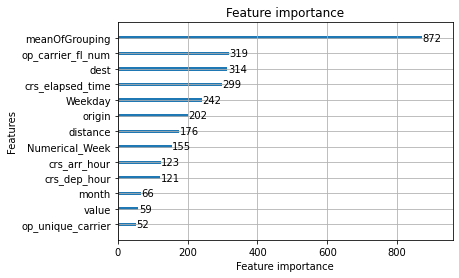

In [56]:
lightgbm.plot_importance(model)